In [2]:
import numpy as np
import pandas as pd 

In [3]:
reviews = pd.read_csv('animal-crossing/user_reviews.csv')

In [4]:
reviews.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

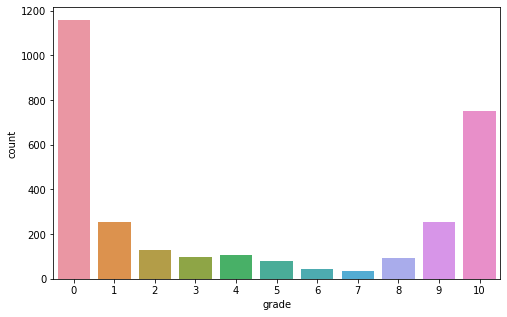

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot("grade", data=reviews)
plt.show()

In [7]:
import nltk
import re
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

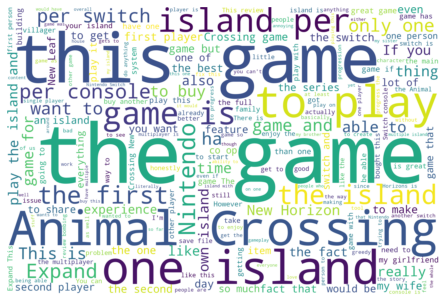

In [8]:
text = ''
for t in reviews.text.values:
    text += f" {t}"
textCloud = WordCloud(width = 3000, height = 2000, background_color = 'white', stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
plt.imshow(textCloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()
del text

In [9]:
reviews = reviews.drop(["user_name", "date"], axis = 1)

In [10]:
reviews.head()

,grade,text
0,4,My gf started playing before me. No option to ...
1,5,"While the game itself is great, really relaxin..."
2,0,My wife and I were looking forward to playing ...
3,0,We need equal values and opportunities for all...
4,0,BEWARE! If you have multiple people in your h...


In [11]:
for i in range(len(reviews)):
    if reviews.grade.values[i] < 5:
        reviews.grade.values[i] = 0
    else:
        reviews.grade.values[i] = 1

In [12]:
y = reviews["grade"].values
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in reviews["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)
del reviews

In [13]:
import gensim

In [14]:
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences = X, size = EMBEDDING_DIM, window = 5, min_count = 1)

In [15]:
len(w2v_model.wv.vocab)

11717

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [17]:
X[0][:10]

[657, 136, 22, 212, 128, 2, 806, 339, 6, 87]

In [18]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

game -> 1
island -> 2
one -> 3
switch -> 4
play -> 5
player -> 6
nintendo -> 7
per -> 8
console -> 9
new -> 10


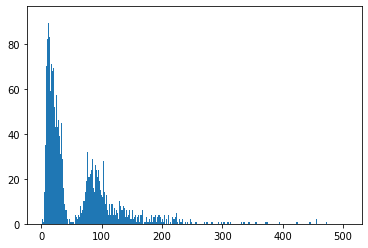

In [19]:
plt.hist([len(x) for x in X], bins = 500)
plt.show()

In [20]:
nos = np.array([len(x) for x in X])
len(nos[nos < 200])

2881

In [21]:
maxlen = 200
X = pad_sequences(X, maxlen = maxlen)

In [22]:
len(X[0])

200

In [23]:
vocab_size = len(tokenizer.word_index) + 1

In [24]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [25]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [26]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
del embedding_vectors

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          1171800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,289,177
Trainable params: 117,377
Non-trainable params: 1,171,800
_________________________________________________________________


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
model.fit(X_train, y_train, validation_split = 0.3, epochs = 10)

Epoch 1/10
50/50 [==============================] - 5s 99ms/step - loss: 0.4219 - acc: 0.8043 - val_loss: 0.4116 - val_acc: 0.8119
Epoch 2/10
50/50 [==============================] - 5s 104ms/step - loss: 0.4053 - acc: 0.8247 - val_loss: 0.4243 - val_acc: 0.8104
Epoch 3/10
50/50 [==============================] - 5s 109ms/step - loss: 0.4043 - acc: 0.8132 - val_loss: 0.4079 - val_acc: 0.8148
Epoch 4/10
50/50 [==============================] - 6s 112ms/step - loss: 0.3801 - acc: 0.8247 - val_loss: 0.4070 - val_acc: 0.8163
Epoch 5/10
50/50 [==============================] - 5s 107ms/step - loss: 0.3641 - acc: 0.8361 - val_loss: 0.3965 - val_acc: 0.8163
Epoch 6/10
50/50 [==============================] - 5s 109ms/step - loss: 0.3581 - acc: 0.8450 - val_loss: 0.4003 - val_acc: 0.8222
Epoch 7/10
50/50 [==============================] - 6s 110ms/step - loss: 0.3622 - acc: 0.8431 - val_loss: 0.3967 - val_acc: 0.8222
Epoch 8/10
50/50 [==============================] - 5s 110ms/step - loss: 0.3

In [34]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [35]:
accuracy_score(y_test, y_pred)

0.8306666666666667